In [39]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 500

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [41]:

device

'cuda'

# AE Arch

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Encoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Encoder, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(64*64*3, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Decoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

    def forward(self, z):
        z = self.linear1(z)
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
from tqdm import tqdm

# AE Training

In [9]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# Date Loading

In [11]:
latent_dims = 512
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('/content/drive/MyDrive/custom_cartoons',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),
        batch_size=32,
        shuffle=True)



In [12]:
data

In [ ]:
autoencoder = train(autoencoder, data)

100%|██████████| 20/20 [25:29<00:00, 76.45s/it]


In [ ]:
z = torch.rand((1, 512)).to(device)

In [ ]:
res = autoencoder.decoder(z)

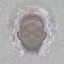

In [ ]:
torchvision.transforms.ToPILImage()(res[0])

# VAE

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(64*64*3, 512)
        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z.to(device)

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train_vae(vae, data)


100%|██████████| 20/20 [22:58<00:00, 68.92s/it]


In [31]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

# Compare AE and VAE Interpolations
- Which is better? 
- Why? 
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


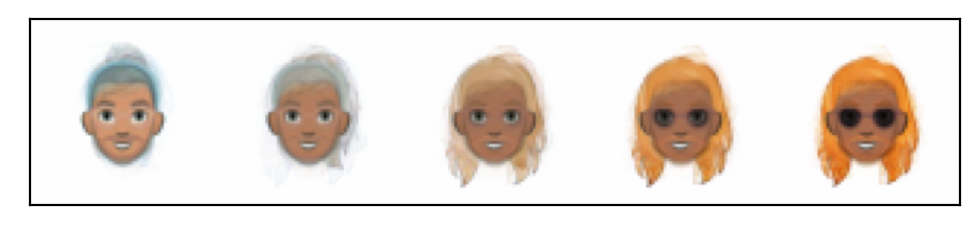

In [ ]:
interpolate(vae, x_1, x_2, n=5)


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


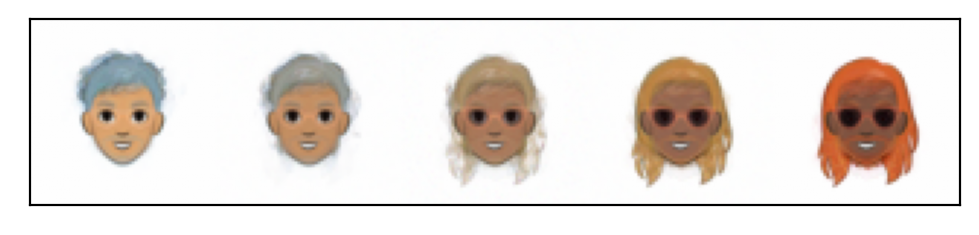

In [ ]:
interpolate(autoencoder, x_1, x_2, n=5)


### Улучшаем VAE

треним

чтобы улучить модель добавим больше слоев, также будем использовать батчнорм, для более быстрого обучения и дропаут в качестве регуляризации 

In [44]:
class NEWVariationalEncoder(nn.Module):
    def __init__(self, latent_dims):

        super(NEWVariationalEncoder, self).__init__()

        self.seq = nn.Sequential(
            nn.Flatten(),

            nn.Linear(64*64*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):

        x = self.seq(x)

        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z.to(device)

In [45]:
class NEWDecoder(nn.Module):
    def __init__(self, latent_dims):

        super(NEWDecoder, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(latent_dims, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 64*64*3)
        )
      

    def forward(self, z):
        z = torch.sigmoid(self.seq(z))
        return z.reshape((-1, 3, 64, 64))

In [46]:
class NEWVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(NEWVariationalAutoencoder, self).__init__()
        self.encoder = NEWVariationalEncoder(latent_dims)
        self.decoder = NEWDecoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [47]:
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [48]:
newvae = NEWVariationalAutoencoder(latent_dims).to(device) # GPU

In [ ]:
newvae = train_vae(newvae, data)

100%|██████████| 20/20 [53:02<00:00, 159.11s/it]


In [ ]:
torch.save(newvae.state_dict(), 'res.pt')

In [49]:
newvae.load_state_dict(torch.load('/content/drive/MyDrive/res.pt'))

<All keys matched successfully>

посмотрим на результат

In [50]:
newvae.eval()

NEWVariationalAutoencoder(
  (encoder): NEWVariationalEncoder(
    (seq): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=12288, out_features=1024, bias=True)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.3, inplace=False)
      (5): Linear(in_features=1024, out_features=512, bias=True)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.3, inplace=False)
    )
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): NEWDecoder(
    (seq): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Dropout(p=0.3, inplace=False)
      (4)

выбираем данные

In [84]:
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

In [22]:
x_1.shape

torch.Size([1, 3, 64, 64])

смотрим на рандомный пример

In [23]:
z = torch.rand((1, 512)).to(device)

In [25]:
res = newvae.decoder(z)

In [26]:
res1 = res.squeeze().shape

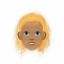

In [30]:
torchvision.transforms.ToPILImage()(res[0])


на семпл примеров

In [29]:
import matplotlib
%matplotlib inline

In [35]:
def interpolate(autoencoder, x_1, x_2, n):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = [newvae.decoder(x) for x in z]
    interpolate_list = interpolate_list #.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat[0])) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

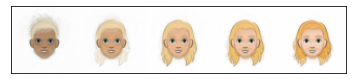

In [36]:
interpolate(newvae, x_1, x_2, n=5)

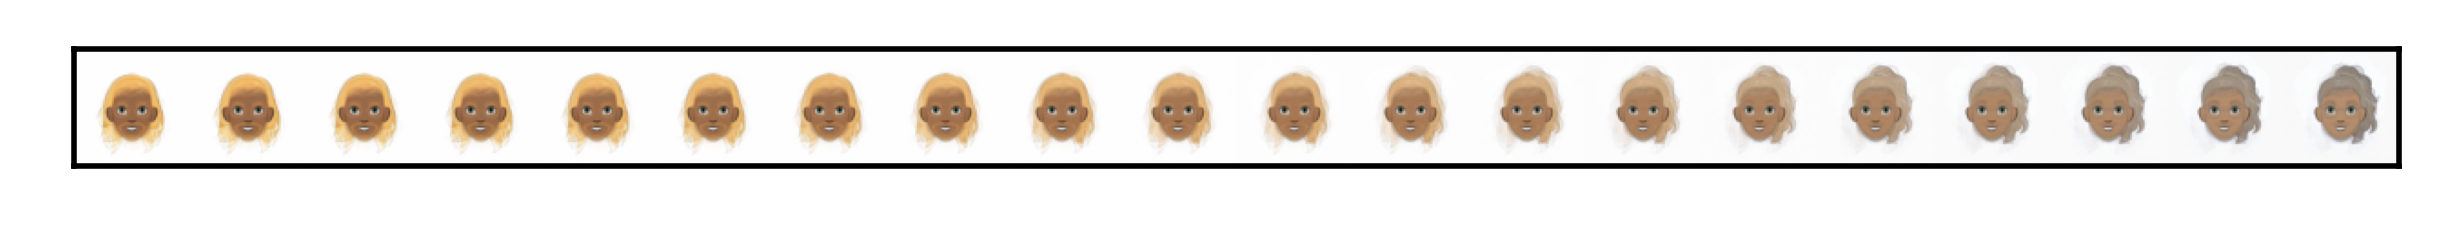

In [85]:
interpolate(newvae, x_1, x_2, n=20)

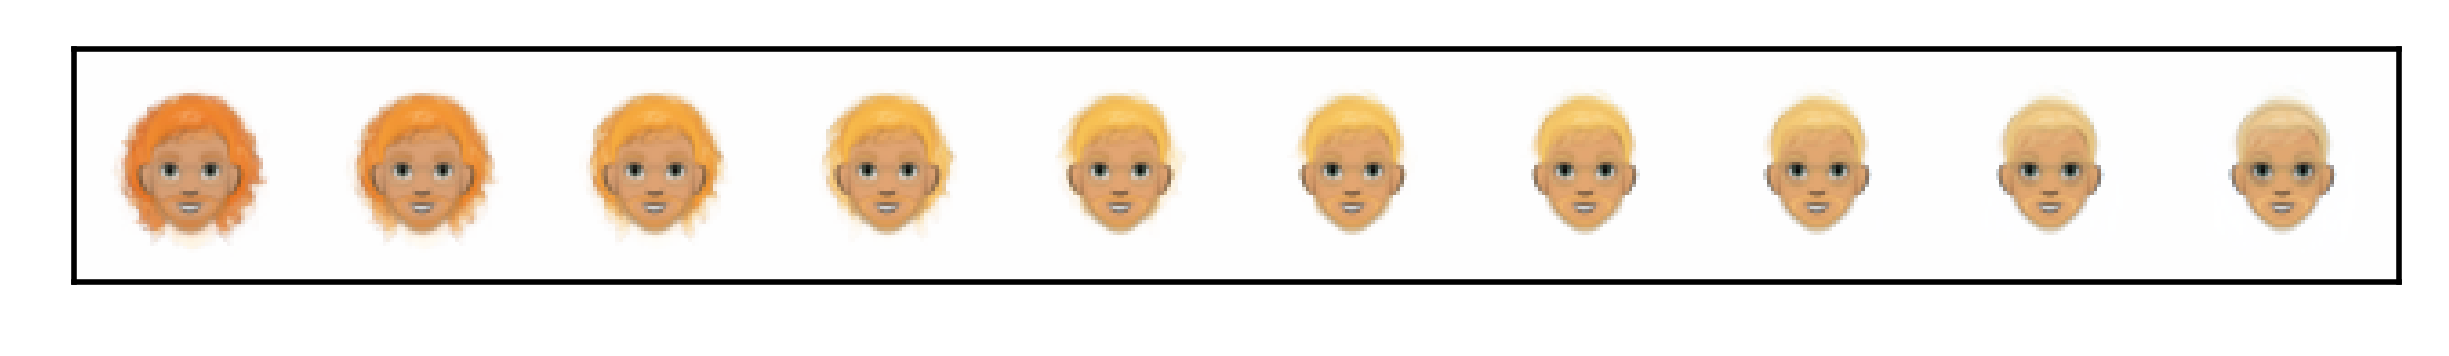

In [81]:
interpolate(newvae, x_1, x_2, n=10)